In [176]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.decomposition import PCA
import logging

# Local modules for quiver construction and Laplacian feature selection
from topology import Cover, Nerve
from harmonic import DualFeatureSelectionProblem

# Configure logging and random seed
logging.basicConfig(level=logging.INFO)
np.random.seed(42)

Dataset shape: (400, 2)


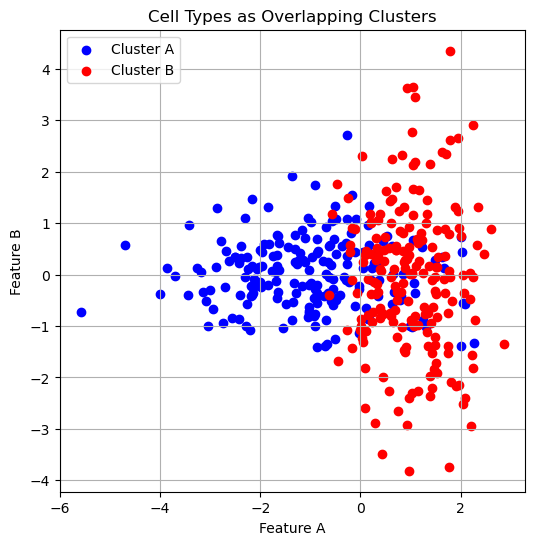

In [177]:
# Cell 2: Generate Synthetic Dataset (Two Overlapping Clusters)
# ----------------------------------------------------------------
# Cluster A: center (-1,0), high x-variance, low y-variance
mean_A, cov_A = [-1, 0], [[2.0, 0.0], [0.0, 0.5]]
# Cluster B: center (1,0), low x-variance, high y-variance
mean_B, cov_B = [1, 0], [[0.5, 0.0], [0.0, 2.0]]

# Draw 200 samples per cluster
points_A = np.random.multivariate_normal(mean_A, cov_A, 200)
points_B = np.random.multivariate_normal(mean_B, cov_B, 200)

# Combine into one dataset X (N×2)
X = np.vstack((points_A, points_B))
print("Dataset shape:", X.shape)

# Visualize data
plt.figure(figsize=(6,6))
plt.scatter(points_A[:,0], points_A[:,1], c='blue', label='Cluster A')
plt.scatter(points_B[:,0], points_B[:,1], c='red',  label='Cluster B')
plt.title("Cell Types as Overlapping Clusters")
plt.xlabel("Feature A")
plt.ylabel("Feature B")
plt.legend()
plt.grid()
plt.show()


In [178]:
# Cell 3: Define Cover (Two Overlapping Patches)
# ----------------------------------------------------------------
# Patch A: first 250 points; Patch B: last 250 points → overlap of 100 points
patch_A = frozenset(range(0, 250))
patch_B = frozenset(range(150, 400))  # indices 200–399; we have 400 points total

cover_subsets = [patch_A, patch_B]
print("Patch A size:", len(patch_A), "Patch B size:", len(patch_B))
print("Overlap size:", len(patch_A & patch_B))


Patch A size: 250 Patch B size: 250
Overlap size: 100


In [179]:
## Cell 4: Build Cover and Nerve (Quiver Vertices + Edges)
# ----------------------------------------------------------------
cover_obj  = Cover(X, cover_subsets)
nerve_obj  = Nerve(cover_obj)  # constructs simplicial complex (nerve of cover)
simplices  = list(nerve_obj.simplicial_complex)
print("Nerve simplices:", simplices)

Nerve simplices: [(0,), (1,), (0, 1)]


 ## Cell 5: PCA per Simplex → Scalar Feature + Principal Direction
 -----------------------------------------------------------------------------
 In the paper’s framework, each cover element (and their nonempty overlaps) is
 a vertex σ in the quiver Q_U. To each vertex we need to assign a feature subspace
 A_σ given by S (our feature selector). Here we will take the one expanded by the top PCA component on the points in σ. In this next cell we won't deffine such an space yet, in fact, we will never do it explicitly. In cell 6 we will see how choosing a kernel function will induce it without the need of defining it. 

 In this cell, for each simplex σ in the nerve:
  1. Extract the local dataset pts = X[list(nerve_obj.simplex_open_set[σ])].

  2. If there are ≥2 points:
       - Fit PCA(n_components=1) on pts.

       - direction = pca.components_[0]   ← unit vector in ℝ² (the local basis for A_σ).
       - pca.transform(pts)               ← 1D projections of pts onto that basis.
     Else (single pt), default direction = [1,0]. ← (This won't really happen)

  3. Aggregate those 1D projections by mean(…) to get a single scalar feature per σ:
       scalar = mean(pca.transform(pts))    ← this is our feature f_σ ∈ A_σ ≅ ℝ (S is slecting a one dimensional space for this it selects f_σ and this will generate the rest of A_σ via linear combinations, i.e., multiplications by scalars in this case).

  4. Save:
       - features[σ] = scalar (1D vector)       ← feature selected at vertex σ.
       - pca_direction[σ]     = direction    ← defines the inclusion map ι^F_σ into V(F)=ℝ².

 Finally, we plot each local PCA line in the global plot:
     line(t) = centroid(pts) + t * direction,  t∈[−5,5]

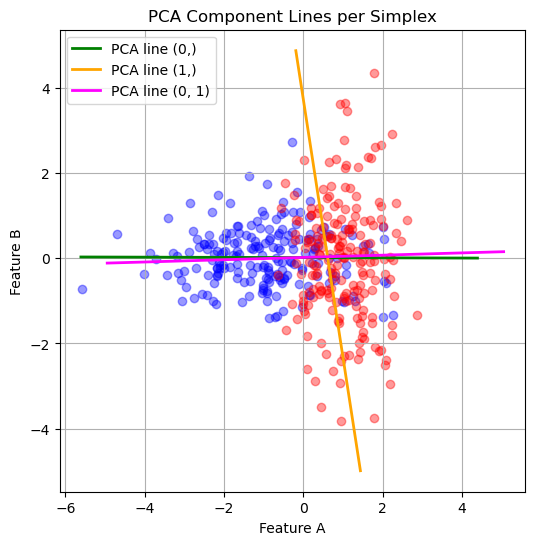

In [180]:
features = {}
pca_direction = {}

plt.figure(figsize=(6,6))
plt.scatter(points_A[:,0], points_A[:,1], c='blue', alpha=0.4)
plt.scatter(points_B[:,0], points_B[:,1], c='red',  alpha=0.4)

color_map = { (0,):'green', (1,):'orange', (0,1):'magenta' }

for sigma in simplices:
    idx = list(nerve_obj.simplex_open_set[sigma])
    pts = X[idx]
    if len(pts)>1:
        pca = PCA(n_components=1).fit(pts)
        scalar    = np.mean(pca.transform(pts), axis=0, keepdims=True)
        direction = pca.components_[0]
    else:
        scalar    = pts.mean(axis=0, keepdims=True)
        direction = np.array([1.0, 0.0])

    features[sigma] = scalar
    pca_direction[sigma]     = direction

    # Plot PCA line
    t = np.linspace(-5,5,100)
    mean = pts.mean(axis=0)
    line = mean + np.outer(t, direction)
    plt.plot(line[:,0], line[:,1],
             c=color_map.get(sigma,'black'),
             lw=2, label=f"PCA line {sigma}")

plt.title("PCA Component Lines per Simplex")
plt.xlabel("Feature A")
plt.ylabel("Feature B")
plt.legend()
plt.grid(True)
plt.show()

## Cell 6: Turning the RBF Kernel into *the* Inner Product on Our 1‑D Feature Stalks

 **1. What is `kernel = RBF(length_scale=1.0)`?**
   
   - It implements
     k(x, y) = exp( −||x−y||² / (2·ℓ²) )
     for scalar inputs x, y ∈ ℝ.  This function is *positive‑definite*, so it can induce an inner product.

 **2. How do we use it to define ⟨·,·⟩ on each subspace Aₛ (where Aₛ = 1‑D span of one scalar feature)?**

   - We store each simplex’s PCA mean as a 1×1 array:
       Xd = np.array([[ f^σ ]])    # shape = (1,1)
       Yd = np.array([[ f^τ ]])    # shape = (1,1)
   - `kernel(Xd, Yd)` returns a 1×1 matrix whose sole entry is k(f^σ, f^τ).
       • If σ==τ, that entry = k(f^σ, f^σ).
   - We add `ε·I` on the **self‑calls** (when Xd.shape == Yd.shape) so
       k(f^σ,f^σ) → k(f^σ,f^σ) + ε > 0
     This guarantees strict positive definiteness (needed for Cholesky factorizations).

 **3. Why does this *induce* an inner product on V(F)?**
   For any two linear combinations
     f = ∑ᵢ αᵢ·(f^σ)ᵢ,   g = ∑ⱼ βⱼ·(f^τ)ᵢ, (Where {(f^σ)ᵢ} and {(f^τ)ⱼ} are repective basis of Aσ and Aτ)
   we *can define*
     ⟨f, g⟩₍V(F)₎ = ∑_{i,j} αᵢ·βⱼ·k((f^σ)ᵢ, (f^τ)ⱼ) 
   Since the Gram matrix [k((f^σ)ᵢ, (f^τ)ⱼ)] is positive‑definite, this bilinear form is
   symmetric, linear in each argument, and positive‑definite—i.e. a true scalar product.

 **4. How does `reg_kernel` feed the quiver Laplacian machinery?**

   - **Diagonal blocks** M_{σσ} = k(f^σ,f^σ)+ε become the metric on each vertex’s stalk.
   - **Off‑diagonal blocks** M_{στ}=k(f^σ,f^τ) become the edge maps π^F_τ ∘ ι^F_σ.
   - In `harmonic.py`, those blocks assemble into the boundary operator B and then L = BᵀB.

 **5. No explicit RKHS needed**  
 
   Moore–Aronszajn Theorem tells us an abstract Φ: X→ℋ exists, but *we* never need to build ℋ or Φ.
   We work directly in the finite span of the 1‑D spaces, using the kernel’s Gram values
   as inner products.  All projections, Laplacians, and eigen‑analyses happen in that space.


In [181]:
kernel = RBF(length_scale=1.0)
epsilon = 1e-10

def reg_kernel(Xd, Yd):
    K = kernel(Xd, Yd)
    if Xd.shape[0] == Yd.shape[0]:
        K += epsilon * np.eye(Xd.shape[0])
    return K

print("Kernel:", kernel)


Kernel: RBF(length_scale=1)


## Cell 7: Instantiate the Dual (Mixed) Feature Selection Problem
---------------------------------------------------------------------------------------------

In the paper there were introduced two types of quiver representations to extract compatible features:

1. **Combined representation** (`OriginalFeatureSelectionProblem`):  
   - Captures only **globally compatible** features—those that survive on **every** simplex (i.e. relevant to all sub‐populations).
   - Sections correspond to features that are simultaneously relevant across all patches.

2. **Mixed representation** (`DualFeatureSelectionProblem`):  
   - Augments each vertex σ with both **primal** and **dual** stalks.
   - Its sections include:
     - **Features relevant to all patches** (present in every patch), and  
     - **Features relevant to some patches** (present in some patches but not all).
   - This lets you discover features that are important to specific sub‐populations, not just universally important ones.

Below we instantiate the **dual problem**, which builds exactly this Mixed representation.  
Its Laplacian eigenvectors will therefore highlight both globally compatible and locally‐specific features.

In [182]:
# %% Cell 7: Instantiate Dual Feature‑Selection Problem
problem_dual = DualFeatureSelectionProblem(
    simplicial_complex=nerve_obj.simplicial_complex,
    simplex_points=features,
    kernel=reg_kernel
)
print("Dual problem ready.")


INFO:root:Starting precomputing matrices
INFO:root:Starting precomputing self kernel matrices
INFO:root:Done precomputing self kernel matrices
INFO:root:Starting precomputing Cholesky factors
INFO:root:Done precomputing Cholesky factors
INFO:root:Starting precomputing kernel matrices
INFO:root:Done precomputing kernel matrices
INFO:root:Starting precomputing there-and-back matrices
INFO:root:Done precomputing there-and-back matrices
INFO:root:Done precomputing matrices


Dual problem ready.


## Cell 8: Compute the Quiver Laplacian & Its Low‐energy Spectrum
---------------------------------------------------------------------------------------------
In this cell we:

1. Build the **Laplacian matrix** L and the **inner‑product matrix** M for the Mixed representation by calling `problem_dual.laplacian()`.  

2. Solve the **generalised eigenproblem** using a small positive **shift** for numerical stability.  

3. Extract the **k** smallest eigenvalues and their eigenvectors:
- An eigenvalue of zero means an **exact section** (a perfectly compatible feature).  
- A small nonzero eigenvalue means an **approximate section** (a feature that is nearly compatible across patches).  

In [183]:
lapprob = problem_dual.laplacian()
N       = lapprob.laplacian_matrix.shape[0]
k       = min(5, N-1)

result = lapprob.low_spectrum(k=k, tol=1e-5, maxiter=1000, shift=1e-1)
print("Eigenvalues:", result.evals)



INFO:root:Computing Laplacian matrix
INFO:root:Finished Laplacian matrix
INFO:root:Computing shift inverse
INFO:root:Starting generalised eigenvector problem:k=2:tol=0.000010:maxiter=1000:shift=0.100000
INFO:root:Finished generalised eigenvector problem


Eigenvalues: [2.77555756e-17 1.00000000e+00]


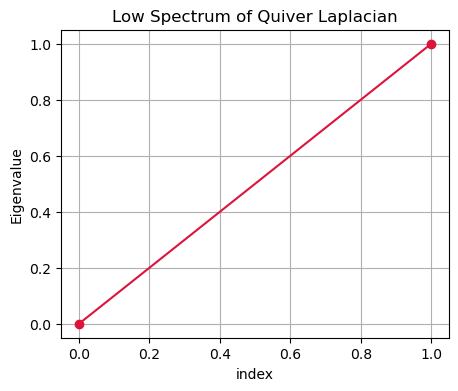

In [184]:
# %% Cell 9: Plot Low Spectrum
plt.figure(figsize=(5,4))
plt.plot(result.evals, 'o-', c='crimson')
plt.title("Low Spectrum of Quiver Laplacian")
plt.xlabel("index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()



In [185]:
# %% Cell 10: Inspect Raw Eigenvectors
print("Smallest eigenvalues:", result.evals)
for i in range(len(result.evals)):
    print(f"eigenvalue number {i}:  eigenvector = {result.evecs[:,i]}")



Smallest eigenvalues: [2.77555756e-17 1.00000000e+00]
eigenvalue number 0:  eigenvector = [0.57735027 0.57735027 0.57735027]
eigenvalue number 1:  eigenvector = [ 5.63520795e-18  7.07106781e-01 -7.07106781e-01]


## Interpretation of Quiver‑Laplacian Eigenvectors
---------------------------------------------------------------------------------------------

Above are the two lowest‑energy eigenvectors of the **Mixed** representation, ordered by increasing eigenvalue:

- **Eigenvector 0** (eigenvalue ≈ 0):  
  - Eigenvector ≈ [0.577, 0.577, 0.577]  
  - **Equal weight** on Patch A, Patch B, and their intersection.  
  - Eigenvalue nearly zero ⇒ an **exact section**, i.e. a perfectly approximated feature. Which we can see that is present *identically* across all subpopulations.  
  - **Interpretation:** the universal, globally compatible feature shared by both clusters and their overlap.

- **Eigenvector 1** (eigenvalue = 1):  
  - Eigenvector ≈ [0, +0.707, –0.707]  
  - **Zero** on Patch A, **positive** on Patch B, **negative** on the intersection.  
  - Eigenvalue > 0 ⇒ an **approximate section**, highlighting the leading deviation from global compatibility.  
  - **Interpretation:** a locally specific feature that distinguishes Patch B from the overlap (and is absent in Patch A), i.e. what makes cluster B unique.

**Summary:**  
- Mode 0 captures the single most **global** feature (present everywhere).  
- Mode 1 captures the top **patch‑specific** contrast (present only in Cluster B’s and consequantly also in the overlap).  

These two modes together fully illustrate the Mixed quiver Laplacian’s ability to extract both globally consistent and locally distinct features. 

## Cell 11: Mapping Laplacian Eigenvectors Back to the Original Feature Space
---------------------------------------------------------------------------------------------

In this cell we take each Laplacian eigenvector, which lives as one scalar per simplex, and turn it into a concrete 2D feature vector over (Feature A, Feature B). This makes the abstract “compatible modes” directly interpretable.

1. **Recover the simplex ordering**  
   We use the exact same list of simplices that was used to build the Laplacian. This guarantees that each entry x_sigma of an eigenvector corresponds to the correct vertex sigma in the quiver.

2. **Use stored PCA directions as inclusion**  
   - In Cell 5 we computed, for each simplex sigma, a unit‑length 2D vector “direction_sigma” that shows how that patch’s PCA feature embeds into the global (A,B) space, i.e, the coordinates of the PCA direction with respect to A,B.  
   - We treat that vector as the image of the basis element “1” in the 1‑dimensional space A_sigma.  
   - By collecting all these vectors side by side, we form an “inclusion matrix” of size 2 by (number of simplices).

3. **Push forward each eigenvector**  
   - A Laplacian eigenvector x is a list of scalars [x_sigma] (one per simplex).  
   - Multiplying the inclusion matrix by x performs the sum:  
     g = sum over sigma of ( x_sigma * direction_sigma )  
   - The result g is a length‑2 vector [w_A, w_B] in the original feature coordinate system that is the result of the linear combination of the PCA directions in which the scalars are given by the coordinates of the eigenvectors.

4. **Normalize and interpret**  
   - We can divide g by its length to get a unit vector pointing in the same direction.  
   - The components [w_A, w_B] tell you exactly how much the mode weights Feature A and Feature B, for example, g = [–0.8, 0.6] means the corresponding eigenvector corresponds to the feature –0.8*A + 0.6*B.


In [186]:
simp_order = list(problem_dual.all_simplices)
cols       = [pca_direction.get(sigma,np.array([1.0,0.0])).reshape(2,1)
              for sigma in simp_order]
inclusion  = np.hstack(cols)            # 2×m

ambient_evecs = inclusion @ result.evecs  # 2×k
for i, λ in enumerate(result.evals):
    g = ambient_evecs[:,i]
    u = g/np.linalg.norm(g)
    print(f"Mode {i}: λ={λ:.4f},  direction = {u}")



Mode 0: λ=0.0000,  direction = [-0.91358903  0.40663876]
Mode 1: λ=1.0000,  direction = [0.64796947 0.76166631]


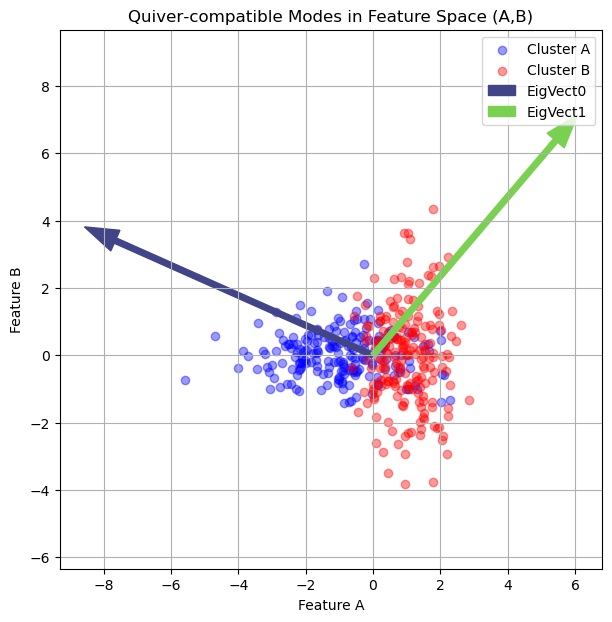

In [187]:
# %% Cell 12: Final Plot – Arrows in Original Feature Space representing the final approximated
# "important fetures" for some subpopulations.
plt.figure(figsize=(7,7))
plt.scatter(points_A[:,0], points_A[:,1], c='blue',  alpha=0.4, label='Cluster A')
plt.scatter(points_B[:,0], points_B[:,1], c='red',   alpha=0.4, label='Cluster B')

extent = np.max(np.abs(X))*1.5
colors = plt.cm.viridis(np.linspace(0.2,0.8,ambient_evecs.shape[1]))

for i in range(ambient_evecs.shape[1]):
    v = ambient_evecs[:,i]
    if np.linalg.norm(v)==0: continue
    d = v/np.linalg.norm(v)
    plt.arrow(0,0, extent*d[0], extent*d[1],
              width=0.02*extent, head_width=0.08*extent,
              color=colors[i], label=f"EigVect{i}")

plt.title("Quiver‑compatible Modes in Feature Space (A,B)")
plt.xlabel("Feature A")
plt.ylabel("Feature B")
plt.legend(loc='upper right')
plt.grid(True)
plt.axis('equal')
plt.show()



## Final Interpretation of the Plot
---------------------------------------------------------------------------------------------

In the scatter+arrow plot above, we overlay the two lowest‑energy eigenmodes of the **Mixed** quiver Laplacian onto the original data:

- **Blue points** = Cluster A  
- **Red points** = Cluster B  
- **Green arrow** (Mode 1) = [0.577, 0.577, 0.577] mode  
- **Navy arrow** (Mode 0) = [0, +0.707, –0.707] mode  

### What We See

1. **Green arrow (Mode 0, eigenvalue ≈ 0)**  
   - Points equally at 45° between Feature A and B.  
   - Reflects the *globally compatible* feature shared by both clusters and their overlap.  
   - Its zero eigenvalue indicates an *exact* section of the Mixed representation.

2. **Navy arrow (Mode 1, eigenvalue = 1)**  
   - Points toward Cluster B’s unique direction (positive on B, negative on the overlap).  
   - Captures the leading *locally specific* feature that distinguishes Patch B from both Patch A and their intersection.  
   - Its nonzero eigenvalue means it’s an *approximate* section—highlighting deviations from perfect global compatibility.

### Take‑home Message

- The **first** eigenmode (green) isolates what is common everywhere (the universal feature).  
- The **second** eigenmode (navy) isolates what is special to two subpopulations (Cluster B and the intersection between A and B).  

This visualization confirms that the Mixed quiver Laplacian successfully recovers the features we wanted in a single spectral framework.  
